In [593]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp

import pickle 

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':23}); plt.rcParams.update({'axes.linewidth':1.5}); plt.rc('axes', axisbelow=True);
plt.rc('lines',linewidth=3); plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 
plt.rcParams['xtick.major.size'] = 8; plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 2; plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 8; plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 2; plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'


import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR

from torch_geometric.nn import SGConv, GCNConv
from torch_geometric.data import Data

### Preprocessing RNA and Tn datasets
!!!: RNA data metadata cols don't match Tn data metadata cols

Don't need them to match exactly, but would prefer the same metadata for each modality

In [479]:
with open('2_PreprocessedData_RbTnSeq.pickle', 'rb') as handle:
    tn = pickle.load(handle)  

with open('2_PreprocessedData_RNASeq_OD.pickle', 'rb') as handle:
    rna = pickle.load(handle)  

Put the data in AnnData format

In [480]:
rna['X'] = rna['X'].T
rna['X'].index = rna['X'].index.astype(str)
rna['metadata'].index = rna['metadata'].index.astype(str)
rna['metadata'].reset_index(inplace=True,drop=True)

rnadata = sc.AnnData(rna['X'])
rnadata.obs = rna['metadata']

In [481]:
tn['X'] = tn['X'].T
tn['X'].index = tn['X'].index.astype(str)
tn['metadata'].index = tn['metadata'].index.astype(str)

tndata = sc.AnnData(tn['X'])
tndata.obs = tn['metadata']

Subset the genes to those in common between RNA and Tn

In [482]:
genes_in_common = list(set(rnadata.var_names).intersection(set(tndata.var_names)) )

# SUBSET TO ONLY 250 GENES TO MAKE MODEL SETUP EASIER
np.random.seed(0)

random_genes = np.random.choice(range(len(genes_in_common)), 250, replace=False)
genes_in_common = [genes_in_common[ii] for ii in random_genes]

rnadata = rnadata[:,genes_in_common].copy()
tndata = tndata[:,genes_in_common].copy()

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Sample QC

### Gene QC

### Sample and Gene Filtering

### Batch effect removal 

In [691]:
sc.pp.combat(tndata, key='BioReplicate', covariates=['condition','TimePoint'], inplace=True)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'BioReplicate' as categorical
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new

### Weighted Gene Co-expression Network 
Question: How should we incorporate multiple experimental conditions? Separate graphs for each? 

We define the adjacency matrix as:

$A_{ij} = \mathrm{corr}(g_i,g_j)^\beta $

Here $\beta$ is a soft thresholding parameter to transform the Pearson correlations between gene $i$ and gene $j$ into a directed edge. 

Note that by construction, $A$ already contains self-loops. Don't add another self-loop during training, a typical procedure when training graph convolutional networks.

In [692]:
beta = 37 # This should be an even number to retain negative weights

if beta % 2 == 0: 
    print('Warning: beta was chosen to be an even integer which is not allowed. please set an odd value. \n The adjacency matrix is not defined.')
else: 
    cor = np.corrcoef(rnadata[rnadata.obs.condition.isin(['NC'])].X.T)
    A = cor ** beta
    A[np.abs(A) <= 10e-4] = 0.0 


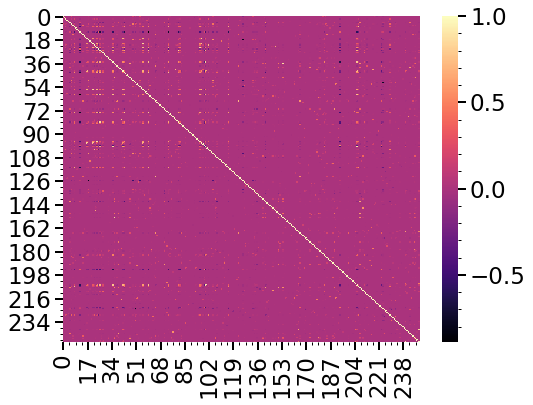

In [693]:
plt.figure(figsize=(8,6))
sns.heatmap(A,cmap='magma')
plt.show()

### Graph edges: `data.edge_index` of shape `[2, num_edges]`


In [694]:
adj = torch.tensor(A,dtype=torch.float32)
edge_index = adj.nonzero().t().contiguous()
edge_index.shape

torch.Size([2, 8448])

In [695]:
edge_index

tensor([[  0,   0,   0,  ..., 249, 249, 249],
        [  0,   2,   5,  ..., 235, 240, 249]])

### Graph edge weights: `data.edge_weight` of shape `[num_edges]` 

In [696]:
row1, row2 = edge_index
edge_weight = adj[row1, row2]

### Node feature matrix: `data.x` of shape  `[num_nodes x num_node_features]`
Using condition `NC` at the moment. Still thinking of how to incorporate all the conditions into the node prediction task. What would be useful? 

In [697]:
x = torch.tensor(tndata[tndata.obs.condition.isin(['NC'])].X.copy().T, dtype=torch.float32)
x_train = x[:,0:7] # BioReplicate 1
x_test = x[:,7:] # BioReplicate 2

### Graph data class

In [698]:
data = Data(x=x_train, edge_index=edge_index, num_nodes=len(x), edge_weight=edge_weight)
# data = Data(x=x, edge_index=edge_index, num_nodes=len(x), edge_weight=edge_weight)

### Node targets: `data.y`
As of now, the targets are one-hots corresponding to which gene was knocked down. Though there may be some other more reasonable approach for formulating the targets

In [699]:
a = np.array([ii for ii in range(len(x))])
y = np.zeros((a.size, a.max() + 1))
y[np.arange(a.size), a] = 1
y = y.transpose() # don't actually need this 
# y = np.arange(0,data.num_nodes)/(data.num_nodes-1)

In [700]:
data.y = torch.tensor(y,dtype=torch.float32)

### Model architecture

EDGE WEIGHTS CAUSE nans in network output. why? 

In [721]:
class Net(torch.nn.Module):
    def __init__(self,data,num_hops):
        super().__init__()
        self.data = data
        num_classes = data.num_nodes # num classes == number of nodes in graph (likely overconstrained..)
        self.conv1 = SGConv(data.num_features, num_classes, K=num_hops, add_self_loops=False, 
                            cached=False) # cached->what does this do, how does it relate to semi-supervision?
# edge_weight=data.edge_weight,
    def forward(self, x):
        edge_index, edge_weight = data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index) # , edge_weight
        
        return x

In [785]:
num_hops = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net(data,num_hops).to(device), data.to(device)

torch.manual_seed(100)

optimizer = torch.optim.Adam(model.parameters(), lr=0.75, weight_decay=1e-6)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.15, momentum=0.0, dampening=0.0, weight_decay=0.0)
scheduler = ExponentialLR(optimizer, gamma=0.999)
criterion = nn.CrossEntropyLoss() # computes softmax and then the cross entropy
# criterion = nn.MSELoss()
# criterion = nn.KLDivLoss()

### Model training

Epoch: 001, Train: 0.0000
Epoch: 002, Train: 0.0160
Epoch: 003, Train: 0.0320
Epoch: 004, Train: 0.0480
Epoch: 005, Train: 0.0840
Epoch: 006, Train: 0.1160
Epoch: 007, Train: 0.1200
Epoch: 008, Train: 0.1680
Epoch: 009, Train: 0.1600
Epoch: 010, Train: 0.1440
Epoch: 011, Train: 0.1200
Epoch: 012, Train: 0.1560
Epoch: 013, Train: 0.1720
Epoch: 014, Train: 0.2120
Epoch: 015, Train: 0.2160
Epoch: 016, Train: 0.2560
Epoch: 017, Train: 0.2960
Epoch: 018, Train: 0.2800
Epoch: 019, Train: 0.2520
Epoch: 020, Train: 0.2360
Epoch: 021, Train: 0.2520
Epoch: 022, Train: 0.2880
Epoch: 023, Train: 0.3280
Epoch: 024, Train: 0.3400
Epoch: 025, Train: 0.3480
Epoch: 026, Train: 0.3720
Epoch: 027, Train: 0.3800
Epoch: 028, Train: 0.3480
Epoch: 029, Train: 0.3560
Epoch: 030, Train: 0.3400
Epoch: 031, Train: 0.3640
Epoch: 032, Train: 0.3840
Epoch: 033, Train: 0.4040
Epoch: 034, Train: 0.4120
Epoch: 035, Train: 0.4360
Epoch: 036, Train: 0.4200
Epoch: 037, Train: 0.3920
Epoch: 038, Train: 0.4360
Epoch: 039, 

Epoch: 334, Train: 0.4520
Epoch: 335, Train: 0.4520
Epoch: 336, Train: 0.4520
Epoch: 337, Train: 0.4520
Epoch: 338, Train: 0.4520
Epoch: 339, Train: 0.4520
Epoch: 340, Train: 0.4520
Epoch: 341, Train: 0.4520
Epoch: 342, Train: 0.4520
Epoch: 343, Train: 0.4520
Epoch: 344, Train: 0.4520
Epoch: 345, Train: 0.4520
Epoch: 346, Train: 0.4520
Epoch: 347, Train: 0.4520
Epoch: 348, Train: 0.4520
Epoch: 349, Train: 0.4520
Epoch: 350, Train: 0.4520
Epoch: 351, Train: 0.4520
Epoch: 352, Train: 0.4520
Epoch: 353, Train: 0.4520
Epoch: 354, Train: 0.4520
Epoch: 355, Train: 0.4520
Epoch: 356, Train: 0.4520
Epoch: 357, Train: 0.4520
Epoch: 358, Train: 0.4520
Epoch: 359, Train: 0.4520
Epoch: 360, Train: 0.4520
Epoch: 361, Train: 0.4520
Epoch: 362, Train: 0.4520
Epoch: 363, Train: 0.4520
Epoch: 364, Train: 0.4520
Epoch: 365, Train: 0.4520
Epoch: 366, Train: 0.4520
Epoch: 367, Train: 0.4520
Epoch: 368, Train: 0.4520
Epoch: 369, Train: 0.4520
Epoch: 370, Train: 0.4520
Epoch: 371, Train: 0.4520
Epoch: 372, 

Epoch: 675, Train: 0.4560
Epoch: 676, Train: 0.4560
Epoch: 677, Train: 0.4560
Epoch: 678, Train: 0.4560
Epoch: 679, Train: 0.4560
Epoch: 680, Train: 0.4560
Epoch: 681, Train: 0.4560
Epoch: 682, Train: 0.4560
Epoch: 683, Train: 0.4560
Epoch: 684, Train: 0.4560
Epoch: 685, Train: 0.4560
Epoch: 686, Train: 0.4560
Epoch: 687, Train: 0.4560
Epoch: 688, Train: 0.4560
Epoch: 689, Train: 0.4560
Epoch: 690, Train: 0.4560
Epoch: 691, Train: 0.4560
Epoch: 692, Train: 0.4560
Epoch: 693, Train: 0.4560
Epoch: 694, Train: 0.4560
Epoch: 695, Train: 0.4560
Epoch: 696, Train: 0.4560
Epoch: 697, Train: 0.4560
Epoch: 698, Train: 0.4560
Epoch: 699, Train: 0.4560
Epoch: 700, Train: 0.4560
Epoch: 701, Train: 0.4560
Epoch: 702, Train: 0.4560
Epoch: 703, Train: 0.4560
Epoch: 704, Train: 0.4560
Epoch: 705, Train: 0.4560
Epoch: 706, Train: 0.4560
Epoch: 707, Train: 0.4560
Epoch: 708, Train: 0.4560
Epoch: 709, Train: 0.4560
Epoch: 710, Train: 0.4560
Epoch: 711, Train: 0.4560
Epoch: 712, Train: 0.4560
Epoch: 713, 

Epoch: 1048, Train: 0.4560
Epoch: 1049, Train: 0.4560
Epoch: 1050, Train: 0.4560
Epoch: 1051, Train: 0.4560
Epoch: 1052, Train: 0.4560
Epoch: 1053, Train: 0.4560
Epoch: 1054, Train: 0.4560
Epoch: 1055, Train: 0.4560
Epoch: 1056, Train: 0.4560
Epoch: 1057, Train: 0.4560
Epoch: 1058, Train: 0.4560
Epoch: 1059, Train: 0.4560
Epoch: 1060, Train: 0.4560
Epoch: 1061, Train: 0.4560
Epoch: 1062, Train: 0.4560
Epoch: 1063, Train: 0.4560
Epoch: 1064, Train: 0.4560
Epoch: 1065, Train: 0.4560
Epoch: 1066, Train: 0.4560
Epoch: 1067, Train: 0.4560
Epoch: 1068, Train: 0.4560
Epoch: 1069, Train: 0.4560
Epoch: 1070, Train: 0.4560
Epoch: 1071, Train: 0.4560
Epoch: 1072, Train: 0.4560
Epoch: 1073, Train: 0.4560
Epoch: 1074, Train: 0.4560
Epoch: 1075, Train: 0.4560
Epoch: 1076, Train: 0.4560
Epoch: 1077, Train: 0.4560
Epoch: 1078, Train: 0.4560
Epoch: 1079, Train: 0.4560
Epoch: 1080, Train: 0.4560
Epoch: 1081, Train: 0.4560
Epoch: 1082, Train: 0.4560
Epoch: 1083, Train: 0.4560
Epoch: 1084, Train: 0.4560
E

Epoch: 1376, Train: 0.4560
Epoch: 1377, Train: 0.4560
Epoch: 1378, Train: 0.4560
Epoch: 1379, Train: 0.4560
Epoch: 1380, Train: 0.4560
Epoch: 1381, Train: 0.4560
Epoch: 1382, Train: 0.4560
Epoch: 1383, Train: 0.4560
Epoch: 1384, Train: 0.4560
Epoch: 1385, Train: 0.4560
Epoch: 1386, Train: 0.4560
Epoch: 1387, Train: 0.4560
Epoch: 1388, Train: 0.4560
Epoch: 1389, Train: 0.4560
Epoch: 1390, Train: 0.4560
Epoch: 1391, Train: 0.4560
Epoch: 1392, Train: 0.4560
Epoch: 1393, Train: 0.4560
Epoch: 1394, Train: 0.4560
Epoch: 1395, Train: 0.4560
Epoch: 1396, Train: 0.4560
Epoch: 1397, Train: 0.4560
Epoch: 1398, Train: 0.4560
Epoch: 1399, Train: 0.4560
Epoch: 1400, Train: 0.4560
Epoch: 1401, Train: 0.4560
Epoch: 1402, Train: 0.4560
Epoch: 1403, Train: 0.4560
Epoch: 1404, Train: 0.4560
Epoch: 1405, Train: 0.4560
Epoch: 1406, Train: 0.4560
Epoch: 1407, Train: 0.4560
Epoch: 1408, Train: 0.4560
Epoch: 1409, Train: 0.4560
Epoch: 1410, Train: 0.4560
Epoch: 1411, Train: 0.4560
Epoch: 1412, Train: 0.4560
E

Epoch: 1705, Train: 0.4560
Epoch: 1706, Train: 0.4560
Epoch: 1707, Train: 0.4560
Epoch: 1708, Train: 0.4560
Epoch: 1709, Train: 0.4560
Epoch: 1710, Train: 0.4560
Epoch: 1711, Train: 0.4560
Epoch: 1712, Train: 0.4560
Epoch: 1713, Train: 0.4560
Epoch: 1714, Train: 0.4560
Epoch: 1715, Train: 0.4560
Epoch: 1716, Train: 0.4560
Epoch: 1717, Train: 0.4560
Epoch: 1718, Train: 0.4560
Epoch: 1719, Train: 0.4560
Epoch: 1720, Train: 0.4560
Epoch: 1721, Train: 0.4560
Epoch: 1722, Train: 0.4560
Epoch: 1723, Train: 0.4560
Epoch: 1724, Train: 0.4560
Epoch: 1725, Train: 0.4560
Epoch: 1726, Train: 0.4560
Epoch: 1727, Train: 0.4560
Epoch: 1728, Train: 0.4560
Epoch: 1729, Train: 0.4560
Epoch: 1730, Train: 0.4560
Epoch: 1731, Train: 0.4560
Epoch: 1732, Train: 0.4560
Epoch: 1733, Train: 0.4560
Epoch: 1734, Train: 0.4560
Epoch: 1735, Train: 0.4560
Epoch: 1736, Train: 0.4560
Epoch: 1737, Train: 0.4560
Epoch: 1738, Train: 0.4560
Epoch: 1739, Train: 0.4560
Epoch: 1740, Train: 0.4560
Epoch: 1741, Train: 0.4560
E

Epoch: 2028, Train: 0.4560
Epoch: 2029, Train: 0.4560
Epoch: 2030, Train: 0.4560
Epoch: 2031, Train: 0.4560
Epoch: 2032, Train: 0.4560
Epoch: 2033, Train: 0.4560
Epoch: 2034, Train: 0.4560
Epoch: 2035, Train: 0.4560
Epoch: 2036, Train: 0.4560
Epoch: 2037, Train: 0.4560
Epoch: 2038, Train: 0.4560
Epoch: 2039, Train: 0.4560
Epoch: 2040, Train: 0.4560
Epoch: 2041, Train: 0.4560
Epoch: 2042, Train: 0.4560
Epoch: 2043, Train: 0.4560
Epoch: 2044, Train: 0.4560
Epoch: 2045, Train: 0.4560
Epoch: 2046, Train: 0.4560
Epoch: 2047, Train: 0.4560
Epoch: 2048, Train: 0.4560
Epoch: 2049, Train: 0.4560
Epoch: 2050, Train: 0.4560
Epoch: 2051, Train: 0.4560
Epoch: 2052, Train: 0.4560
Epoch: 2053, Train: 0.4560
Epoch: 2054, Train: 0.4560
Epoch: 2055, Train: 0.4560
Epoch: 2056, Train: 0.4560
Epoch: 2057, Train: 0.4560
Epoch: 2058, Train: 0.4560
Epoch: 2059, Train: 0.4560
Epoch: 2060, Train: 0.4560
Epoch: 2061, Train: 0.4560
Epoch: 2062, Train: 0.4560
Epoch: 2063, Train: 0.4560
Epoch: 2064, Train: 0.4560
E

Epoch: 2338, Train: 0.4560
Epoch: 2339, Train: 0.4560
Epoch: 2340, Train: 0.4560
Epoch: 2341, Train: 0.4560
Epoch: 2342, Train: 0.4560
Epoch: 2343, Train: 0.4560
Epoch: 2344, Train: 0.4560
Epoch: 2345, Train: 0.4560
Epoch: 2346, Train: 0.4560
Epoch: 2347, Train: 0.4560
Epoch: 2348, Train: 0.4560
Epoch: 2349, Train: 0.4560
Epoch: 2350, Train: 0.4560
Epoch: 2351, Train: 0.4560
Epoch: 2352, Train: 0.4560
Epoch: 2353, Train: 0.4560
Epoch: 2354, Train: 0.4560
Epoch: 2355, Train: 0.4560
Epoch: 2356, Train: 0.4560
Epoch: 2357, Train: 0.4560
Epoch: 2358, Train: 0.4560
Epoch: 2359, Train: 0.4560
Epoch: 2360, Train: 0.4560
Epoch: 2361, Train: 0.4560
Epoch: 2362, Train: 0.4560
Epoch: 2363, Train: 0.4560
Epoch: 2364, Train: 0.4560
Epoch: 2365, Train: 0.4560
Epoch: 2366, Train: 0.4560
Epoch: 2367, Train: 0.4560
Epoch: 2368, Train: 0.4560
Epoch: 2369, Train: 0.4560
Epoch: 2370, Train: 0.4560
Epoch: 2371, Train: 0.4560
Epoch: 2372, Train: 0.4560
Epoch: 2373, Train: 0.4560
Epoch: 2374, Train: 0.4560
E

Epoch: 2667, Train: 0.4560
Epoch: 2668, Train: 0.4560
Epoch: 2669, Train: 0.4560
Epoch: 2670, Train: 0.4560
Epoch: 2671, Train: 0.4560
Epoch: 2672, Train: 0.4560
Epoch: 2673, Train: 0.4560
Epoch: 2674, Train: 0.4560
Epoch: 2675, Train: 0.4560
Epoch: 2676, Train: 0.4560
Epoch: 2677, Train: 0.4560
Epoch: 2678, Train: 0.4560
Epoch: 2679, Train: 0.4560
Epoch: 2680, Train: 0.4560
Epoch: 2681, Train: 0.4560
Epoch: 2682, Train: 0.4560
Epoch: 2683, Train: 0.4560
Epoch: 2684, Train: 0.4560
Epoch: 2685, Train: 0.4560
Epoch: 2686, Train: 0.4560
Epoch: 2687, Train: 0.4560
Epoch: 2688, Train: 0.4560
Epoch: 2689, Train: 0.4560
Epoch: 2690, Train: 0.4560
Epoch: 2691, Train: 0.4560
Epoch: 2692, Train: 0.4560
Epoch: 2693, Train: 0.4560
Epoch: 2694, Train: 0.4560
Epoch: 2695, Train: 0.4560
Epoch: 2696, Train: 0.4560
Epoch: 2697, Train: 0.4560
Epoch: 2698, Train: 0.4560
Epoch: 2699, Train: 0.4560
Epoch: 2700, Train: 0.4560
Epoch: 2701, Train: 0.4560
Epoch: 2702, Train: 0.4560
Epoch: 2703, Train: 0.4560
E

Epoch: 2997, Train: 0.4560
Epoch: 2998, Train: 0.4560
Epoch: 2999, Train: 0.4560
Epoch: 3000, Train: 0.4560
Epoch: 3001, Train: 0.4560
Epoch: 3002, Train: 0.4560
Epoch: 3003, Train: 0.4560
Epoch: 3004, Train: 0.4560
Epoch: 3005, Train: 0.4560
Epoch: 3006, Train: 0.4560
Epoch: 3007, Train: 0.4560
Epoch: 3008, Train: 0.4560
Epoch: 3009, Train: 0.4560
Epoch: 3010, Train: 0.4560
Epoch: 3011, Train: 0.4560
Epoch: 3012, Train: 0.4560
Epoch: 3013, Train: 0.4560
Epoch: 3014, Train: 0.4560
Epoch: 3015, Train: 0.4560
Epoch: 3016, Train: 0.4560
Epoch: 3017, Train: 0.4560
Epoch: 3018, Train: 0.4560
Epoch: 3019, Train: 0.4560
Epoch: 3020, Train: 0.4560
Epoch: 3021, Train: 0.4560
Epoch: 3022, Train: 0.4560
Epoch: 3023, Train: 0.4560
Epoch: 3024, Train: 0.4560
Epoch: 3025, Train: 0.4560
Epoch: 3026, Train: 0.4560
Epoch: 3027, Train: 0.4560
Epoch: 3028, Train: 0.4560
Epoch: 3029, Train: 0.4560
Epoch: 3030, Train: 0.4560
Epoch: 3031, Train: 0.4560
Epoch: 3032, Train: 0.4560
Epoch: 3033, Train: 0.4560
E

Epoch: 3327, Train: 0.4560
Epoch: 3328, Train: 0.4560
Epoch: 3329, Train: 0.4560
Epoch: 3330, Train: 0.4560
Epoch: 3331, Train: 0.4560
Epoch: 3332, Train: 0.4560
Epoch: 3333, Train: 0.4560
Epoch: 3334, Train: 0.4560
Epoch: 3335, Train: 0.4560
Epoch: 3336, Train: 0.4560
Epoch: 3337, Train: 0.4560
Epoch: 3338, Train: 0.4560
Epoch: 3339, Train: 0.4560
Epoch: 3340, Train: 0.4560
Epoch: 3341, Train: 0.4560
Epoch: 3342, Train: 0.4560
Epoch: 3343, Train: 0.4560
Epoch: 3344, Train: 0.4560
Epoch: 3345, Train: 0.4560
Epoch: 3346, Train: 0.4560
Epoch: 3347, Train: 0.4560
Epoch: 3348, Train: 0.4560
Epoch: 3349, Train: 0.4560
Epoch: 3350, Train: 0.4560
Epoch: 3351, Train: 0.4560
Epoch: 3352, Train: 0.4560
Epoch: 3353, Train: 0.4560
Epoch: 3354, Train: 0.4560
Epoch: 3355, Train: 0.4560
Epoch: 3356, Train: 0.4560
Epoch: 3357, Train: 0.4560
Epoch: 3358, Train: 0.4560
Epoch: 3359, Train: 0.4560
Epoch: 3360, Train: 0.4560
Epoch: 3361, Train: 0.4560
Epoch: 3362, Train: 0.4560
Epoch: 3363, Train: 0.4560
E

Epoch: 3657, Train: 0.4560
Epoch: 3658, Train: 0.4560
Epoch: 3659, Train: 0.4560
Epoch: 3660, Train: 0.4560
Epoch: 3661, Train: 0.4560
Epoch: 3662, Train: 0.4560
Epoch: 3663, Train: 0.4560
Epoch: 3664, Train: 0.4560
Epoch: 3665, Train: 0.4560
Epoch: 3666, Train: 0.4560
Epoch: 3667, Train: 0.4560
Epoch: 3668, Train: 0.4560
Epoch: 3669, Train: 0.4560
Epoch: 3670, Train: 0.4560
Epoch: 3671, Train: 0.4560
Epoch: 3672, Train: 0.4560
Epoch: 3673, Train: 0.4560
Epoch: 3674, Train: 0.4560
Epoch: 3675, Train: 0.4560
Epoch: 3676, Train: 0.4560
Epoch: 3677, Train: 0.4560
Epoch: 3678, Train: 0.4560
Epoch: 3679, Train: 0.4560
Epoch: 3680, Train: 0.4560
Epoch: 3681, Train: 0.4560
Epoch: 3682, Train: 0.4560
Epoch: 3683, Train: 0.4560
Epoch: 3684, Train: 0.4560
Epoch: 3685, Train: 0.4560
Epoch: 3686, Train: 0.4560
Epoch: 3687, Train: 0.4560
Epoch: 3688, Train: 0.4560
Epoch: 3689, Train: 0.4560
Epoch: 3690, Train: 0.4560
Epoch: 3691, Train: 0.4560
Epoch: 3692, Train: 0.4560
Epoch: 3693, Train: 0.4560
E

Epoch: 3988, Train: 0.4560
Epoch: 3989, Train: 0.4560
Epoch: 3990, Train: 0.4560
Epoch: 3991, Train: 0.4560
Epoch: 3992, Train: 0.4560
Epoch: 3993, Train: 0.4560
Epoch: 3994, Train: 0.4560
Epoch: 3995, Train: 0.4560
Epoch: 3996, Train: 0.4560
Epoch: 3997, Train: 0.4560
Epoch: 3998, Train: 0.4560
Epoch: 3999, Train: 0.4560
Epoch: 4000, Train: 0.4560
Epoch: 4001, Train: 0.4560
Epoch: 4002, Train: 0.4560
Epoch: 4003, Train: 0.4560
Epoch: 4004, Train: 0.4560
Epoch: 4005, Train: 0.4560
Epoch: 4006, Train: 0.4560
Epoch: 4007, Train: 0.4560
Epoch: 4008, Train: 0.4560
Epoch: 4009, Train: 0.4560
Epoch: 4010, Train: 0.4560
Epoch: 4011, Train: 0.4560
Epoch: 4012, Train: 0.4560
Epoch: 4013, Train: 0.4560
Epoch: 4014, Train: 0.4560
Epoch: 4015, Train: 0.4560
Epoch: 4016, Train: 0.4560
Epoch: 4017, Train: 0.4560
Epoch: 4018, Train: 0.4560
Epoch: 4019, Train: 0.4560
Epoch: 4020, Train: 0.4560
Epoch: 4021, Train: 0.4560
Epoch: 4022, Train: 0.4560
Epoch: 4023, Train: 0.4560
Epoch: 4024, Train: 0.4560
E

Epoch: 4324, Train: 0.4560
Epoch: 4325, Train: 0.4560
Epoch: 4326, Train: 0.4560
Epoch: 4327, Train: 0.4560
Epoch: 4328, Train: 0.4560
Epoch: 4329, Train: 0.4560
Epoch: 4330, Train: 0.4560
Epoch: 4331, Train: 0.4560
Epoch: 4332, Train: 0.4560
Epoch: 4333, Train: 0.4560
Epoch: 4334, Train: 0.4560
Epoch: 4335, Train: 0.4560
Epoch: 4336, Train: 0.4560
Epoch: 4337, Train: 0.4560
Epoch: 4338, Train: 0.4560
Epoch: 4339, Train: 0.4560
Epoch: 4340, Train: 0.4560
Epoch: 4341, Train: 0.4560
Epoch: 4342, Train: 0.4560
Epoch: 4343, Train: 0.4560
Epoch: 4344, Train: 0.4560
Epoch: 4345, Train: 0.4560
Epoch: 4346, Train: 0.4560
Epoch: 4347, Train: 0.4560
Epoch: 4348, Train: 0.4560
Epoch: 4349, Train: 0.4560
Epoch: 4350, Train: 0.4560
Epoch: 4351, Train: 0.4560
Epoch: 4352, Train: 0.4560
Epoch: 4353, Train: 0.4560
Epoch: 4354, Train: 0.4560
Epoch: 4355, Train: 0.4560
Epoch: 4356, Train: 0.4560
Epoch: 4357, Train: 0.4560
Epoch: 4358, Train: 0.4560
Epoch: 4359, Train: 0.4560
Epoch: 4360, Train: 0.4560
E

Epoch: 4653, Train: 0.4560
Epoch: 4654, Train: 0.4560
Epoch: 4655, Train: 0.4560
Epoch: 4656, Train: 0.4560
Epoch: 4657, Train: 0.4560
Epoch: 4658, Train: 0.4560
Epoch: 4659, Train: 0.4560
Epoch: 4660, Train: 0.4560
Epoch: 4661, Train: 0.4560
Epoch: 4662, Train: 0.4560
Epoch: 4663, Train: 0.4560
Epoch: 4664, Train: 0.4560
Epoch: 4665, Train: 0.4560
Epoch: 4666, Train: 0.4560
Epoch: 4667, Train: 0.4560
Epoch: 4668, Train: 0.4560
Epoch: 4669, Train: 0.4560
Epoch: 4670, Train: 0.4560
Epoch: 4671, Train: 0.4560
Epoch: 4672, Train: 0.4560
Epoch: 4673, Train: 0.4560
Epoch: 4674, Train: 0.4560
Epoch: 4675, Train: 0.4560
Epoch: 4676, Train: 0.4560
Epoch: 4677, Train: 0.4560
Epoch: 4678, Train: 0.4560
Epoch: 4679, Train: 0.4560
Epoch: 4680, Train: 0.4560
Epoch: 4681, Train: 0.4560
Epoch: 4682, Train: 0.4560
Epoch: 4683, Train: 0.4560
Epoch: 4684, Train: 0.4560
Epoch: 4685, Train: 0.4560
Epoch: 4686, Train: 0.4560
Epoch: 4687, Train: 0.4560
Epoch: 4688, Train: 0.4560
Epoch: 4689, Train: 0.4560
E

Epoch: 4976, Train: 0.4560
Epoch: 4977, Train: 0.4560
Epoch: 4978, Train: 0.4560
Epoch: 4979, Train: 0.4560
Epoch: 4980, Train: 0.4560
Epoch: 4981, Train: 0.4560
Epoch: 4982, Train: 0.4560
Epoch: 4983, Train: 0.4560
Epoch: 4984, Train: 0.4560
Epoch: 4985, Train: 0.4560
Epoch: 4986, Train: 0.4560
Epoch: 4987, Train: 0.4560
Epoch: 4988, Train: 0.4560
Epoch: 4989, Train: 0.4560
Epoch: 4990, Train: 0.4560
Epoch: 4991, Train: 0.4560
Epoch: 4992, Train: 0.4560
Epoch: 4993, Train: 0.4560
Epoch: 4994, Train: 0.4560
Epoch: 4995, Train: 0.4560
Epoch: 4996, Train: 0.4560
Epoch: 4997, Train: 0.4560
Epoch: 4998, Train: 0.4560
Epoch: 4999, Train: 0.4560
Epoch: 5000, Train: 0.4560


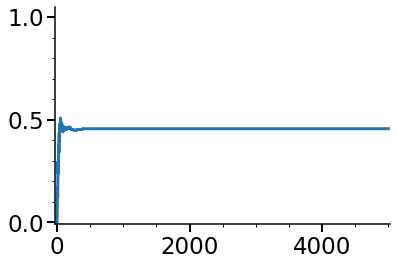

In [786]:
train_acc = []
num_epochs = 5001
for ii, epoch in enumerate(range(1, num_epochs)):
    model.train(True) # for gradient tracking 
    
    optimizer.zero_grad()
    yhat = model(x_train)
    loss = criterion(yhat, data.y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    model.train(False) # don't need to track gradients for metrics
#     acc = np.linalg.norm(yhat.detach() - y)
#     train_acc.append(acc)
    corrects = (yhat.argmax(dim=1) == data.y.argmax(dim=1))
    train_acc.append( (corrects.sum()/data.y.size(1)).item() )
    print(f'Epoch: {epoch:03d}, Train: {train_acc[ii]:.4f}')
    
plt.plot(train_acc); plt.xlim(-25,num_epochs+25); plt.ylim(-0.01,1.05)
plt.show()

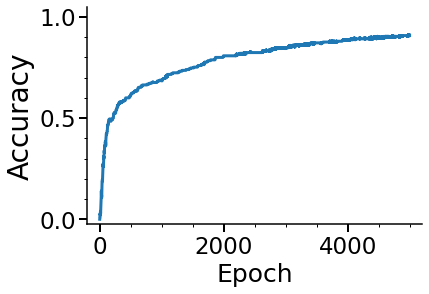

In [773]:
plt.plot(train_acc)
plt.xlabel('Epoch',fontsize=25); plt.ylabel('Accuracy',fontsize=28)
plt.xlim(-200,num_epochs+200)
plt.ylim(-0.025, 1.05)
plt.show()

In [774]:
print('incorrects')
np.nonzero(yhat.detach().numpy().argmax(axis=1) - np.argmax(y,axis=1))

incorrects


(array([  8,  21,  24,  25,  26,  47,  49,  60,  71,  73,  74,  82,  96,
        100, 108, 151, 154, 180, 207, 208, 210, 224, 227]),)

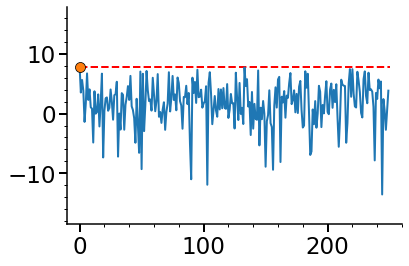

In [775]:
which_gene = 0
plt.plot(yhat.detach()[which_gene,:],lw=2)
plt.plot(which_gene,yhat.detach()[which_gene,which_gene],'o',c='tab:orange',ms=10,mec='k',mew=0.75)
plt.plot([0,data.num_nodes],[yhat.detach()[which_gene,which_gene],yhat.detach()[which_gene,which_gene]],
        c='r',lw=2,linestyle='--',zorder=0)
plt.xlim(-10,data.num_nodes+10)
plt.ylim(yhat.detach()[which_gene,:].min()-5, yhat.detach()[which_gene,:].max()+10)
plt.show()

### Model evaluation

In [787]:
model.eval()
yhat_test = model(x_test)

In [788]:
corrects = (yhat_test.argmax(dim=1) == data.y.argmax(dim=1))
test_acc = (corrects.sum()/data.y.size(1)).item()

In [789]:
test_acc

0.03200000151991844

In [ ]:
def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

### GCNConv

In [284]:
# GCN model with 3 layers 
class Net(torch.nn.Module):
    def __init__(self, n_hidden):
        super(Net, self).__init__()
        num_classes = data.num_nodes
        self.conv1 = GCNConv(data.num_features, n_hidden, add_self_loops=False)
        self.conv2 = GCNConv(n_hidden, n_hidden, add_self_loops=False)
        self.conv3 = GCNConv(n_hidden, int(num_classes), add_self_loops=False)
        # How to include edge weights? 
        
    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = nn.functional.relu(self.conv1(x, edge_index))
        x = nn.functional.dropout(x, training=self.training)
        x = nn.functional.relu(self.conv2(x, edge_index))
        x = nn.functional.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [285]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_hidden = 250
model, data = Net(num_hidden).to(device), data.to(device)

torch.manual_seed(42)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0075, weight_decay=0.05)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.1, dampening=0, weight_decay=0.05)
scheduler = ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss() # computes softmax and then the cross entropy

Epoch: 010, Train: 0.0080
Epoch: 020, Train: 0.0120
Epoch: 030, Train: 0.0080
Epoch: 040, Train: 0.0040
Epoch: 050, Train: 0.0040
Epoch: 060, Train: 0.0040
Epoch: 070, Train: 0.0080
Epoch: 080, Train: 0.0120
Epoch: 090, Train: 0.0040
Epoch: 100, Train: 0.0080


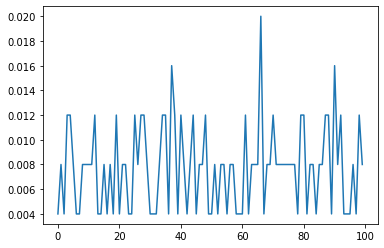

In [286]:
train_acc = []
for ii, epoch in enumerate(range(1, 101)):
    model.train(True) # for gradient tracking 
    
    optimizer.zero_grad()
    yhat = model()
    loss = criterion(yhat, data.y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    model.train(False) # don't need to track gradients for metrics
    corrects = (yhat.argmax(dim=0) == data.y.argmax(dim=0))
    train_acc.append( (corrects.sum()/data.y.size(1)).item() )
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch:03d}, Train: {train_acc[ii]:.4f}')
    
plt.plot(train_acc)


In [120]:
corrects.sum()

tensor(1)

### Logistic Regression on fitness data to classify gene knockdown

In [682]:
from sklearn.linear_model import LogisticRegression

In [710]:
y_lr = np.arange(0,data.num_nodes)

In [711]:
lr = LogisticRegression(multi_class='multinomial',C=10)
lr = lr.fit(data.x.numpy(), y_lr)

In [712]:
lr.predict(data.x.numpy())

array([  0, 130,  95, 155,   4, 108,  91,  98,  38,   9, 233, 216,  66,
       163, 167, 182,  98,  38,  18,  19, 243,  21,  22,  23, 102,  38,
       138,  27, 126,  29, 230,  31,  32,  21,  34,  35, 108, 129,  38,
        39, 125, 125,  42,  43,  44,  68, 216,  47,  98, 216,  50,  51,
        52,  53,  54,  55, 152,  57,  95,  59,  60,  61, 223,  66,  51,
        65,  66,  67,  68,  94, 174,  71,  60, 129, 236,  75,  76, 202,
        44, 186,  22, 108, 137,  83,  84, 190,  75, 211, 157,  89, 235,
        91,  44,  93,  19,  95, 135,  34,  98,  99, 146,  21, 102, 138,
        66,  48,   4, 107, 108, 129, 110, 223, 126, 125, 114, 216, 179,
       120, 118,  44, 120, 138, 122, 123, 124, 125, 126, 211,  92, 129,
       130, 131,  66,  51, 134, 135,  32, 137, 138, 139, 140, 141, 142,
        60, 110, 124, 146, 147, 125, 149,  91, 151, 152, 153, 154, 155,
       138, 157, 158, 159,  98, 152, 162,  89,   4, 235, 125, 167, 168,
        44,  66, 171, 172, 141,   4, 202,  67, 235, 130, 179,  1

In [717]:
len(np.where(lr.predict(data.x.numpy()) - y_lr==0)[0])/250

0.46

In [718]:
len(np.where(lr.predict(x_test) - y_lr==0)[0])/250

0.024